## CNN 스팸 메일 분류

### 데이터 로드 및 전처리

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<ipython-input-3-4cc5b33a9de7>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


* https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename='spam.csv')
data = pd.read_csv('spam.csv', encoding = 'latin-1')
print(len(data))

5572


In [ ]:
data[:10]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [ ]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'], [0,1]) # ham이면 0, spam이면 1
data[:10]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [ ]:
data.drop_duplicates(subset=['v2'], inplace = True)
len(data) # 중복내용 제거

5169

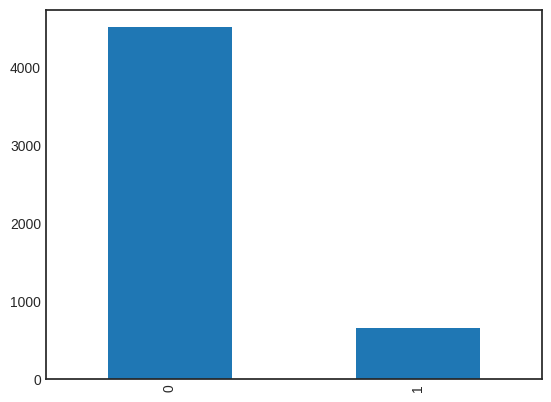

In [ ]:
data['v1'].value_counts().plot(kind='bar');

In [ ]:
data.groupby('v1').size().reset_index(name='count') # v1에 대해 group지정해주고 size보기 0: 4516개, 1: 653개

,v1,count
0,0,4516
1,1,653


In [ ]:
X_data = data['v2']
y_data = data['v1']

In [ ]:
vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

In [ ]:
sequences[:5]# 길이가 제각각

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137],
 [49, 306, 435, 6],
 [53,
  537,
  8,
  20,
  4,
  934,
  2,
  220,
  706,
  267,
  70,
  2,
  2,
  359,
  537,
  604,
  82,
  436,
  185,
  707,
  437],
 [6, 226, 152, 23, 347, 6, 138, 145, 56, 152],
 [935, 1, 97, 96, 69, 453, 2, 877, 69, 198, 105, 438]]

In [ ]:
X_data = sequences

print('메일 최대 길이 : {}'.format(max(len(l) for l in X_data)))
print('메일 평균 길이 : {}'.format((sum(map(len, X_data))/len(X_data))))

메일 최대 길이 : 172
메일 평균 길이 : 12.566840781582512


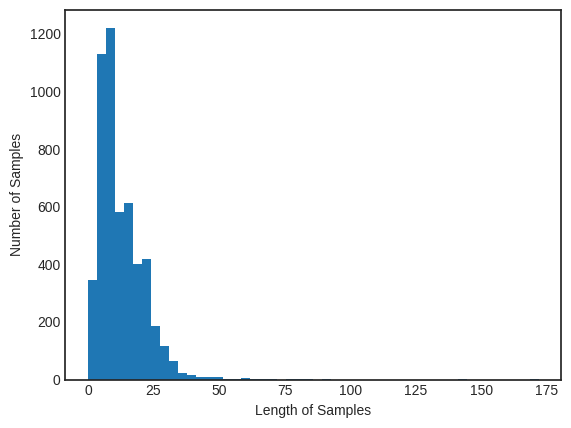

In [ ]:
plt.hist([len(s) for s in X_data], bins = 50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
max_len = 60
data = pad_sequences(X_data, maxlen= max_len)
print(data.shape)

(5169, 60)


In [ ]:
n_train = int(len(sequences) * 0.8)
n_test = int(len(sequences) - n_train)

print(n_train)
print(n_test)

4135
1034


In [ ]:
X_train = data[:n_train]
y_train = np.array(y_data[:n_train])
X_test = data[n_train:]
y_test = np.array(y_data[n_train:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4135, 60)
(4135,)
(1034, 60)
(1034,)


### 모델 구성

In [ ]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model =Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2)) # 과적합방지
model.add(Conv1D(32,5, strides=1, padding='valid',activation='relu')) # 1차원 합성곱
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          32000     
                                                                 
 dropout_1 (Dropout)         (None, None, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          5152      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode='max', verbose=1, save_brst_only=True)

### 모델 학습

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[es, mc])

Epoch 1/10
51/52 [============================>.] - ETA: 0s - loss: 0.4884 - acc: 0.8594
Epoch 1: saving model to best_model.h5
52/52 [==============================] - 2s 16ms/step - loss: 0.4867 - acc: 0.8597 - val_loss: 0.3801 - val_acc: 0.8730
Epoch 2/10
12/52 [=====>........................] - ETA: 0s - loss: 0.3460 - acc: 0.8893

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/52 [===========================>..] - ETA: 0s - loss: 0.3674 - acc: 0.8715
Epoch 2: saving model to best_model.h5
52/52 [==============================] - 1s 12ms/step - loss: 0.3685 - acc: 0.8697 - val_loss: 0.3189 - val_acc: 0.8730
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.2068 - acc: 0.9075
Epoch 3: saving model to best_model.h5
52/52 [==============================] - 1s 12ms/step - loss: 0.2068 - acc: 0.9075 - val_loss: 0.0985 - val_acc: 0.9794
Epoch 4/10
47/52 [==========================>...] - ETA: 0s - loss: 0.0673 - acc: 0.9837
Epoch 4: saving model to best_model.h5
52/52 [==============================] - 1s 11ms/step - loss: 0.0648 - acc: 0.9840 - val_loss: 0.0520 - val_acc: 0.9843
Epoch 5/10
52/52 [==============================] - ETA: 0s - loss: 0.0393 - acc: 0.9894
Epoch 5: saving model to best_model.h5
52/52 [==============================] - 1s 12ms/step - loss: 0.0393 - acc: 0.9894 - val_loss: 0.0500 - val_acc: 0.9807
Epoch 6/10
50/52 [=

### 시각화

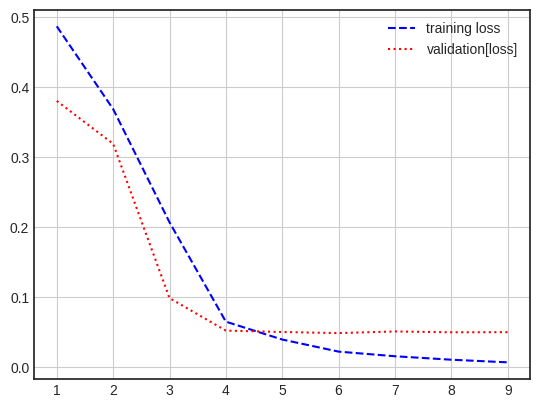

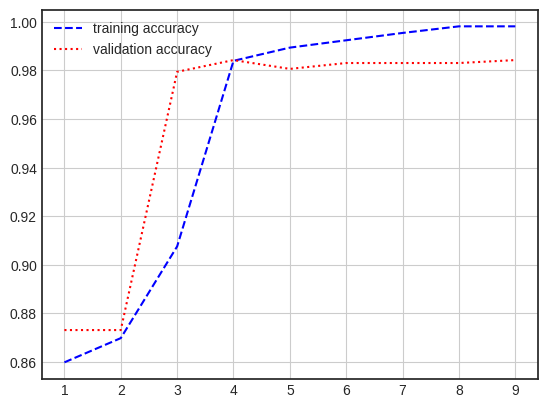

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b--', label='training loss')
plt.plot(epochs, val_loss,'r:',label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs,acc,'b--', label ='training accuracy')
plt.plot(epochs, val_acc, 'r:', label = 'validation accuracy')
plt.grid()
plt.legend()

plt.show()
# 훌륭하게 학습됨

In [ ]:
model.evaluate(X_test, y_test)
# 98%로 높은 성능으로 모델이 학습

33/33 [==============================] - 0s 5ms/step - loss: 0.0585 - acc: 0.9884


[0.05850912630558014, 0.988394558429718]